Connected to finetuning (Python 3.10.4)

In [ ]:
# Import necessary libraries and functions from helper modules
import sys
sys.path.append('../plm_circuits')

# Import utility functions
from helpers.utils import (
    clear_memory,
    load_esm,
    load_sae_prot,
    mask_flanks_segment,
    patching_metric,
    cleanup_cuda
)

# Import attribution functions
from attribution import (
    integrated_gradients_sae,
    topk_sae_err_pt
)

# Import hook classes
from hook_manager import SAEHookProt

# Additional imports
import json
from functools import partial
import torch
import numpy as np
import matplotlib.pyplot as plt
import collections

In IPython
Set autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
In IPython
Set autoreload


In [ ]:
# Setup device and load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ESM-2 model
esm_transformer, batch_converter, esm2_alphabet = load_esm(33, device=device)

# Load SAEs for multiple layers
main_layers = [4, 8, 12, 16, 20, 24, 28]
saes = []
for layer in main_layers:
    sae_model = load_sae_prot(ESM_DIM=1280, SAE_DIM=4096, LAYER=layer, device=device)
    saes.append(sae_model)

layer_2_saelayer = {layer: layer_idx for layer_idx, layer in enumerate(main_layers)}

Using device: cuda


In [ ]:
# Load sequence data and define protein parameters
with open('../data/full_seq_dict.json', "r") as json_file:
    seq_dict = json.load(json_file)

# Define protein-specific parameters
sse_dict = {"2B61A": [[182, 316]], "1PVGA": [[101, 202]]}
fl_dict = {"2B61A": [44, 43], "1PVGA": [65, 63]}

# Choose protein for analysis
protein = "2B61A"
seq = seq_dict[protein]
position = sse_dict[protein][0]

# Define segment boundaries
ss1_start = position[0] - 5 
ss1_end = position[0] + 5 + 1 
ss2_start = position[1] - 5 
ss2_end = position[1] + 5 + 1 

print(f"Analyzing protein: {protein}")
print(f"Sequence length: {len(seq)}")
print(f"Segment 1: {ss1_start}-{ss1_end}")
print(f"Segment 2: {ss2_start}-{ss2_end}")

Analyzing protein: 2B61A
Sequence length: 377
Segment 1: 177-188
Segment 2: 311-322


In [ ]:
# Prepare full sequence and get baseline contact predictions
full_seq_L = [(1, seq)]
_, _, batch_tokens_BL = batch_converter(full_seq_L)
batch_tokens_BL = batch_tokens_BL.to(device)
batch_mask_BL = (batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    full_seq_contact_LL = esm_transformer.predict_contacts(batch_tokens_BL, batch_mask_BL)[0]

# Prepare clean sequence (with optimal flanks)
clean_fl = fl_dict[protein][0]
L = len(seq)
left_start = max(0, ss1_start - clean_fl)
left_end = ss1_start
right_start = ss2_end
right_end = min(L, ss2_end + clean_fl)
unmask_left_idxs = list(range(left_start, left_end))
unmask_right_idxs = list(range(right_start, right_end))

clean_seq_L = mask_flanks_segment(seq, ss1_start, ss1_end, ss2_start, ss2_end, unmask_left_idxs, unmask_right_idxs)
_, _, clean_batch_tokens_BL = batch_converter([(1, clean_seq_L)])
clean_batch_tokens_BL = clean_batch_tokens_BL.to(device)
clean_batch_mask_BL = (clean_batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    clean_seq_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]

print(f"Clean flank size: {clean_fl}")
print(f"Clean sequence contact recovery: {patching_metric(clean_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end):.4f}")

# Prepare corrupted sequence (with suboptimal flanks)
corr_fl = fl_dict[protein][1]
left_start = max(0, ss1_start - corr_fl)
left_end = ss1_start
right_start = ss2_end
right_end = min(L, ss2_end + corr_fl)
unmask_left_idxs = list(range(left_start, left_end))
unmask_right_idxs = list(range(right_start, right_end))

corr_seq_L = mask_flanks_segment(seq, ss1_start, ss1_end, ss2_start, ss2_end, unmask_left_idxs, unmask_right_idxs)
_, _, corr_batch_tokens_BL = batch_converter([(1, corr_seq_L)])
corr_batch_tokens_BL = corr_batch_tokens_BL.to(device)
corr_batch_mask_BL = (corr_batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    corr_seq_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]

print(f"Corrupted flank size: {corr_fl}")
print(f"Corrupted sequence contact recovery: {patching_metric(corr_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end):.4f}")

# Create patching metric function
_patching_metric = partial(
    patching_metric,
    orig_contact=full_seq_contact_LL,
    ss1_start=ss1_start,
    ss1_end=ss1_end,
    ss2_start=ss2_start,
    ss2_end=ss2_end,
)

Clean flank size: 44
Clean sequence contact recovery: 0.5738
Corrupted flank size: 43
Corrupted sequence contact recovery: 0.0279


In [ ]:
# Perform causal ranking for all latent-token pairs across layers
print("Starting causal ranking with integrated gradients...")

all_effects_sae_ALS = []
all_effects_err_ABLF = []

for layer_idx in main_layers:
    print(f"\nProcessing layer {layer_idx}...")
    
    sae_model = saes[layer_2_saelayer[layer_idx]]

    # Get clean cache and error
    hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, cache_latents=True, layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        clean_seq_sae_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    clean_cache_LS = sae_model.feature_acts
    clean_err_cache_BLF = sae_model.error_term
    clean_contact_recovery = _patching_metric(clean_seq_sae_contact_LL)

    # Get corrupted cache and error
    hook = SAEHookProt(sae=sae_model, mask_BL=corr_batch_mask_BL, cache_latents=True, layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        corr_seq_sae_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    corr_cache_LS = sae_model.feature_acts
    corr_err_cache_BLF = sae_model.error_term
    corr_contact_recovery = _patching_metric(corr_seq_sae_contact_LL)
    
    print(f"Layer {layer_idx}: Clean contact recovery: {clean_contact_recovery:.4f}, Corr contact recovery: {corr_contact_recovery:.4f}")

    # Run integrated gradients
    effect_sae_LS, effect_err_BLF = integrated_gradients_sae(
        esm_transformer,
        sae_model,
        _patching_metric,
        clean_cache_LS.to(device),
        corr_cache_LS.to(device),
        clean_err_cache_BLF.to(device),
        corr_err_cache_BLF.to(device),
        batch_tokens=clean_batch_tokens_BL,
        batch_mask=clean_batch_mask_BL,
        hook_layer=layer_idx,
    )

    all_effects_sae_ALS.append(effect_sae_LS)
    all_effects_err_ABLF.append(effect_err_BLF)

# Stack all effects
all_effects_sae_ALS = torch.stack(all_effects_sae_ALS)
all_effects_err_ABLF = torch.stack(all_effects_err_ABLF)

print(f"\nCausal ranking complete!")
print(f"SAE effects shape: {all_effects_sae_ALS.shape}")
print(f"Error effects shape: {all_effects_err_ABLF.shape}")

Starting causal ranking with integrated gradients...

Processing layer 4...
Layer 4: Clean contact recovery: 0.5738, Corr contact recovery: 0.0279
ratio: 0.0, score: 0.5737996101379395
ratio: 0.1, score: 0.601131796836853
ratio: 0.2, score: 0.4815935492515564
ratio: 0.30000000000000004, score: 0.4985087811946869
ratio: 0.4, score: 0.3368060886859894
ratio: 0.5, score: 0.2868437170982361
ratio: 0.6000000000000001, score: 0.24697260558605194
ratio: 0.7000000000000001, score: 0.12411289662122726
ratio: 0.8, score: 0.10038772225379944
ratio: 0.9, score: 0.033265773206949234

Processing layer 8...
Layer 8: Clean contact recovery: 0.5738, Corr contact recovery: 0.0279
ratio: 0.0, score: 0.5737998485565186
ratio: 0.1, score: 0.5733504891395569
ratio: 0.2, score: 0.49743935465812683
ratio: 0.30000000000000004, score: 0.4819444417953491
ratio: 0.4, score: 0.4560147225856781
ratio: 0.5, score: 0.3371899425983429
ratio: 0.6000000000000001, score: 0.24517741799354553
ratio: 0.7000000000000001, sco

In [ ]:
target_layer = 4
sae_model = saes[layer_2_saelayer[target_layer]]
target_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[target_layer]]
target_effect_sae_flat_LxS = target_effect_sae_LS.reshape(-1)

top_rank_vals, top_idx = torch.topk(target_effect_sae_flat_LxS, k=10, largest=False, sorted=True)
print(top_rank_vals)

tensor([-0.0259, -0.0236, -0.0187, -0.0187, -0.0174, -0.0155, -0.0120, -0.0118,
        -0.0117, -0.0117])


In [ ]:
target_layer = 4
sae_model = saes[layer_2_saelayer[target_layer]]
target_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[target_layer]]
target_effect_sae_flat_LxS = target_effect_sae_LS.reshape(-1)

top_rank_vals, top_idx = torch.topk(target_effect_sae_flat_LxS, k=10, largest=False, sorted=True)
print(top_rank_vals)

# Convert flattened indices back to 2D coordinates
L, S = target_effect_sae_LS.shape
row_indices = top_idx // S
col_indices = top_idx % S

print(f"Top 10 positions (row, col):")
for i in range(len(top_idx)):
    row = row_indices[i]
    col = col_indices[i]
    value = top_rank_vals[i]
    print(f"  Rank {i+1}: ({row}, {col}) = {value:.6f}")

tensor([-0.0259, -0.0236, -0.0187, -0.0187, -0.0174, -0.0155, -0.0120, -0.0118,
        -0.0117, -0.0117])
Top 10 positions (row, col):
  Rank 1: (356, 2443) = -0.025851
  Rank 2: (356, 3651) = -0.023650
  Rank 3: (356, 963) = -0.018743
  Rank 4: (367, 340) = -0.018701
  Rank 5: (367, 237) = -0.017374
  Rank 6: (356, 1474) = -0.015493
  Rank 7: (356, 794) = -0.011983
  Rank 8: (356, 443) = -0.011848
  Rank 9: (356, 2340) = -0.011689
  Rank 10: (132, 3788) = -0.011680


In [ ]:
K = 25
target_layer = 4
sae_model = saes[layer_2_saelayer[target_layer]]
target_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[target_layer]]
target_effect_sae_flat_LxS = target_effect_sae_LS.reshape(-1)

top_rank_vals, top_idx = torch.topk(target_effect_sae_flat_LxS, k=K, largest=False, sorted=True)
print(top_rank_vals)

# Convert flattened indices back to 2D coordinates
L, S = target_effect_sae_LS.shape
row_indices = top_idx // S
col_indices = top_idx % S

print(f"Top {K} positions (row, col):")
for i in range(len(top_idx)):
    row = row_indices[i]
    col = col_indices[i]
    value = top_rank_vals[i]
    print(f"  Rank {i+1}: ({row}, {col}) = {value:.6f}")

tensor([-0.0259, -0.0236, -0.0187, -0.0187, -0.0174, -0.0155, -0.0120, -0.0118,
        -0.0117, -0.0117, -0.0106, -0.0105, -0.0094, -0.0088, -0.0082, -0.0080,
        -0.0078, -0.0075, -0.0069, -0.0069, -0.0067, -0.0065, -0.0063, -0.0063,
        -0.0062])
Top 25 positions (row, col):
  Rank 1: (356, 2443) = -0.025851
  Rank 2: (356, 3651) = -0.023650
  Rank 3: (356, 963) = -0.018743
  Rank 4: (367, 340) = -0.018701
  Rank 5: (367, 237) = -0.017374
  Rank 6: (356, 1474) = -0.015493
  Rank 7: (356, 794) = -0.011983
  Rank 8: (356, 443) = -0.011848
  Rank 9: (356, 2340) = -0.011689
  Rank 10: (132, 3788) = -0.011680
  Rank 11: (356, 3701) = -0.010640
  Rank 12: (356, 2311) = -0.010532
  Rank 13: (160, 2277) = -0.009393
  Rank 14: (356, 3153) = -0.008762
  Rank 15: (362, 798) = -0.008174
  Rank 16: (160, 3634) = -0.008025
  Rank 17: (182, 1682) = -0.007824
  Rank 18: (363, 1690) = -0.007468
  Rank 19: (356, 3764) = -0.006891
  Rank 20: (356, 3326) = -0.006855
  Rank 21: (370, 1096) = -0.

In [ ]:
K = 25
target_layer = 4
sae_model = saes[layer_2_saelayer[target_layer]]
target_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[target_layer]]
target_effect_sae_flat_LxS = target_effect_sae_LS.reshape(-1)

top_rank_vals, top_idx = torch.topk(target_effect_sae_flat_LxS, k=K, largest=False, sorted=True)
print(top_rank_vals)

# Convert flattened indices back to 2D coordinates
L, S = target_effect_sae_LS.shape
row_indices = top_idx // S
col_indices = top_idx % S

print(f"Top {K} positions (row, col):")
for i in range(len(top_idx)):
    row = row_indices[i]
    col = col_indices[i]
    value = top_rank_vals[i]
    print(f"  Rank {i+1}: (Token {row}, Latent {col}) = {value:.6f}")

tensor([-0.0259, -0.0236, -0.0187, -0.0187, -0.0174, -0.0155, -0.0120, -0.0118,
        -0.0117, -0.0117, -0.0106, -0.0105, -0.0094, -0.0088, -0.0082, -0.0080,
        -0.0078, -0.0075, -0.0069, -0.0069, -0.0067, -0.0065, -0.0063, -0.0063,
        -0.0062])
Top 25 positions (row, col):
  Rank 1: (Token 356, Latent 2443) = -0.025851
  Rank 2: (Token 356, Latent 3651) = -0.023650
  Rank 3: (Token 356, Latent 963) = -0.018743
  Rank 4: (Token 367, Latent 340) = -0.018701
  Rank 5: (Token 367, Latent 237) = -0.017374
  Rank 6: (Token 356, Latent 1474) = -0.015493
  Rank 7: (Token 356, Latent 794) = -0.011983
  Rank 8: (Token 356, Latent 443) = -0.011848
  Rank 9: (Token 356, Latent 2340) = -0.011689
  Rank 10: (Token 132, Latent 3788) = -0.011680
  Rank 11: (Token 356, Latent 3701) = -0.010640
  Rank 12: (Token 356, Latent 2311) = -0.010532
  Rank 13: (Token 160, Latent 2277) = -0.009393
  Rank 14: (Token 356, Latent 3153) = -0.008762
  Rank 15: (Token 362, Latent 798) = -0.008174
  Rank 1

In [ ]:
print("Creating layer-wise caches for performance analysis...")

clean_layer_caches = {}
corr_layer_caches = {}
clean_layer_errors = {}
corr_layer_errors = {}

for layer_idx in main_layers:
    sae_model = saes[layer_2_saelayer[layer_idx]]
    
    # Clean caches
    hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, cache_latents=True, 
                       layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        clean_seq_sae_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    print(f"Layer {layer_idx}, clean score: {_patching_metric(clean_seq_sae_contact_LL):.4f}")
    clean_layer_caches[layer_idx] = sae_model.feature_acts
    clean_layer_errors[layer_idx] = sae_model.error_term
    # print shapes
    print(clean_layer_caches[layer_idx].shape, clean_layer_errors[layer_idx].shape)

    # Corrupted caches
    hook = SAEHookProt(sae=sae_model, mask_BL=corr_batch_mask_BL, cache_latents=True, 
                       layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        corr_seq_sae_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    print(f"Layer {layer_idx}, corr score: {_patching_metric(corr_seq_sae_contact_LL):.4f}")
    corr_layer_caches[layer_idx] = sae_model.feature_acts
    corr_layer_errors[layer_idx] = sae_model.error_term

print("Layer-wise caches created successfully!")

Creating layer-wise caches for performance analysis...
Layer 4, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 4, corr score: 0.0279
Layer 8, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 8, corr score: 0.0279
Layer 12, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 12, corr score: 0.0279
Layer 16, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 16, corr score: 0.0279
Layer 20, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 20, corr score: 0.0279
Layer 24, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 24, corr score: 0.0279
Layer 28, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 28, corr score: 0.0279
Layer-wise caches created successfully!


In [ ]:
sae_mask_LS = torch.ones((L, S), dtype=torch.bool, device=device)
sae_model_list, esm_transformer = clear_memory([sae_model], esm_transformer)
sae_model = sae_model_list[0]

In [ ]:
for i in range(len(top_idx)):
    row = row_indices[i]
    col = col_indices[i]
    sae_mask_LS[row, col] = False

hook = SAEHookProt(
        sae=sae_model,
        mask_BL=clean_batch_mask_BL,
        patch_mask_BLS=sae_mask_LS.to(device),
        patch_value=corr_layer_caches[target_layer].to(device),
        use_mean_error=True,
    )
handle = esm_transformer.esm.encoder.layer[target_layer].register_forward_hook(hook)

# Forward pass & metric
with torch.no_grad():
    preds_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
rec = _patching_metric(preds_LL)

# Clean up
handle.remove()
cleanup_cuda()

print(f"Corrupted sequence contact recovery: {rec:.4f}")

Corrupted sequence contact recovery: 0.0144


In [ ]:
K = 50
target_layer = 4
sae_model = saes[layer_2_saelayer[target_layer]]
target_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[target_layer]]
target_effect_sae_flat_LxS = target_effect_sae_LS.reshape(-1)

top_rank_vals, top_idx = torch.topk(target_effect_sae_flat_LxS, k=K, largest=False, sorted=True)
print(top_rank_vals)

# Convert flattened indices back to 2D coordinates
L, S = target_effect_sae_LS.shape
row_indices = top_idx // S
col_indices = top_idx % S

print(f"Top {K} positions (row, col):")
for i in range(len(top_idx)):
    row = row_indices[i]
    col = col_indices[i]
    value = top_rank_vals[i]
    print(f"  Rank {i+1}: (Token {row}, Latent {col}) = {value:.6f}")

tensor([-0.0259, -0.0236, -0.0187, -0.0187, -0.0174, -0.0155, -0.0120, -0.0118,
        -0.0117, -0.0117, -0.0106, -0.0105, -0.0094, -0.0088, -0.0082, -0.0080,
        -0.0078, -0.0075, -0.0069, -0.0069, -0.0067, -0.0065, -0.0063, -0.0063,
        -0.0062, -0.0062, -0.0061, -0.0057, -0.0057, -0.0057, -0.0053, -0.0053,
        -0.0052, -0.0047, -0.0047, -0.0046, -0.0045, -0.0043, -0.0043, -0.0043,
        -0.0043, -0.0042, -0.0041, -0.0041, -0.0040, -0.0040, -0.0039, -0.0038,
        -0.0038, -0.0038])
Top 50 positions (row, col):
  Rank 1: (Token 356, Latent 2443) = -0.025851
  Rank 2: (Token 356, Latent 3651) = -0.023650
  Rank 3: (Token 356, Latent 963) = -0.018743
  Rank 4: (Token 367, Latent 340) = -0.018701
  Rank 5: (Token 367, Latent 237) = -0.017374
  Rank 6: (Token 356, Latent 1474) = -0.015493
  Rank 7: (Token 356, Latent 794) = -0.011983
  Rank 8: (Token 356, Latent 443) = -0.011848
  Rank 9: (Token 356, Latent 2340) = -0.011689
  Rank 10: (Token 132, Latent 3788) = -0.01168

In [ ]:
sae_mask_LS = torch.ones((L, S), dtype=torch.bool, device=device)
sae_model_list, esm_transformer = clear_memory([sae_model], esm_transformer)
sae_model = sae_model_list[0]

In [ ]:
for i in range(len(top_idx)):
    row = row_indices[i]
    col = col_indices[i]
    sae_mask_LS[row, col] = False

hook = SAEHookProt(
        sae=sae_model,
        mask_BL=clean_batch_mask_BL,
        patch_mask_BLS=sae_mask_LS.to(device),
        patch_value=corr_layer_caches[target_layer].to(device),
        use_mean_error=True,
    )
handle = esm_transformer.esm.encoder.layer[target_layer].register_forward_hook(hook)

# Forward pass & metric
with torch.no_grad():
    preds_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
rec = _patching_metric(preds_LL)

# Clean up
handle.remove()
cleanup_cuda()

print(f"Corrupted sequence contact recovery: {rec:.4f}")

Corrupted sequence contact recovery: 0.6088


In [ ]:
def sweep_k_values(target_layers, k_values, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches,
                  saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL,
                  _patching_metric, device):
    """
    Sweep through k values for multiple target layers and collect recovery scores.
    
    Returns:
        results: Dictionary with layer as key, and (k_values, recoveries) as values
    """
    
    results = {}
    
    for target_layer in target_layers:
        print(f"\nProcessing layer {target_layer}...")
        recoveries = []
        
        for k in k_values:
            recovery = patch_top_k_features(
                target_layer, k, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches,
                saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL,
                _patching_metric, device, verbose=True
            )
            recoveries.append(recovery)
            
        results[target_layer] = (k_values, recoveries)
        print(f"Layer {target_layer} complete!")
    
    return results

In [ ]:
# Define parameters for the sweep
target_layers = [4, 8, 12, 16, 20]  # You can modify this list
k_values = [1, 5, 10, 20, 50, 100, 200]  # You can modify this list

print("Starting k-value sweep across layers...")

# Clear memory before starting
sae_model_list, esm_transformer = clear_memory(saes, esm_transformer)
saes = sae_model_list

# Run the sweep
sweep_results = sweep_k_values(
    target_layers, k_values, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches,
    saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL,
    _patching_metric, device
)

print("Sweep complete!")

Starting k-value sweep across layers...

Processing layer 4...


NameError: name 'patch_top_k_features' is not defined

In [ ]:
def patch_top_k_features(target_layer, k_value, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches, 
                        saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL, 
                        _patching_metric, device, verbose=False):
    """
    Patch the top-k most important features for a given layer and return recovery score.
    
    Args:
        target_layer: Layer to patch
        k_value: Number of top features to patch
        ... (other arguments are the data structures from above)
        verbose: Whether to print debug info
    
    Returns:
        recovery: Contact recovery score after patching
    """
    
    # Get the SAE model and effects for this layer
    sae_model = saes[layer_2_saelayer[target_layer]]
    target_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[target_layer]]
    target_effect_sae_flat_LxS = target_effect_sae_LS.reshape(-1)
    
    # Get top-k indices
    top_rank_vals, top_idx = torch.topk(target_effect_sae_flat_LxS, k=k_value, largest=False, sorted=True)
    
    # Convert flattened indices back to 2D coordinates
    L, S = target_effect_sae_LS.shape
    row_indices = top_idx // S
    col_indices = top_idx % S
    
    if verbose:
        print(f"Layer {target_layer}, K={k_value}: Top effect = {top_rank_vals[0]:.6f}")
    
    # Create mask - start with all True (don't patch), set False for positions to patch
    sae_mask_LS = torch.ones((L, S), dtype=torch.bool, device=device)
    
    for i in range(len(top_idx)):
        row = row_indices[i]
        col = col_indices[i]
        sae_mask_LS[row, col] = False
    
    # Set up hook for patching
    hook = SAEHookProt(
        sae=sae_model,
        mask_BL=clean_batch_mask_BL,
        patch_mask_BLS=sae_mask_LS.to(device),
        patch_value=corr_layer_caches[target_layer].to(device),
        use_mean_error=True,
    )
    handle = esm_transformer.esm.encoder.layer[target_layer].register_forward_hook(hook)
    
    # Forward pass & metric
    with torch.no_grad():
        preds_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    recovery = _patching_metric(preds_LL)
    
    # Clean up
    handle.remove()
    cleanup_cuda()
    
    return recovery

In [ ]:
# Define parameters for the sweep
target_layers = [4, 8, 12, 16, 20]  # You can modify this list
k_values = [1, 5, 10, 20, 50, 100, 200]  # You can modify this list

print("Starting k-value sweep across layers...")

# Clear memory before starting
sae_model_list, esm_transformer = clear_memory(saes, esm_transformer)
saes = sae_model_list

# Run the sweep
sweep_results = sweep_k_values(
    target_layers, k_values, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches,
    saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL,
    _patching_metric, device
)

print("Sweep complete!")

Starting k-value sweep across layers...

Processing layer 4...
Layer 4, K=1: Top effect = -0.025851
Layer 4, K=5: Top effect = -0.025851
Layer 4, K=10: Top effect = -0.025851
Layer 4, K=20: Top effect = -0.025851
Layer 4, K=50: Top effect = -0.025851
Layer 4, K=100: Top effect = -0.025851
Layer 4, K=200: Top effect = -0.025851
Layer 4 complete!

Processing layer 8...
Layer 8, K=1: Top effect = -0.017311
Layer 8, K=5: Top effect = -0.017311
Layer 8, K=10: Top effect = -0.017311
Layer 8, K=20: Top effect = -0.017311
Layer 8, K=50: Top effect = -0.017311
Layer 8, K=100: Top effect = -0.017311
Layer 8, K=200: Top effect = -0.017311
Layer 8 complete!

Processing layer 12...
Layer 12, K=1: Top effect = -0.022354
Layer 12, K=5: Top effect = -0.022354
Layer 12, K=10: Top effect = -0.022354
Layer 12, K=20: Top effect = -0.022354
Layer 12, K=50: Top effect = -0.022354
Layer 12, K=100: Top effect = -0.022354
Layer 12, K=200: Top effect = -0.022354
Layer 12 complete!

Processing layer 16...
Layer 

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

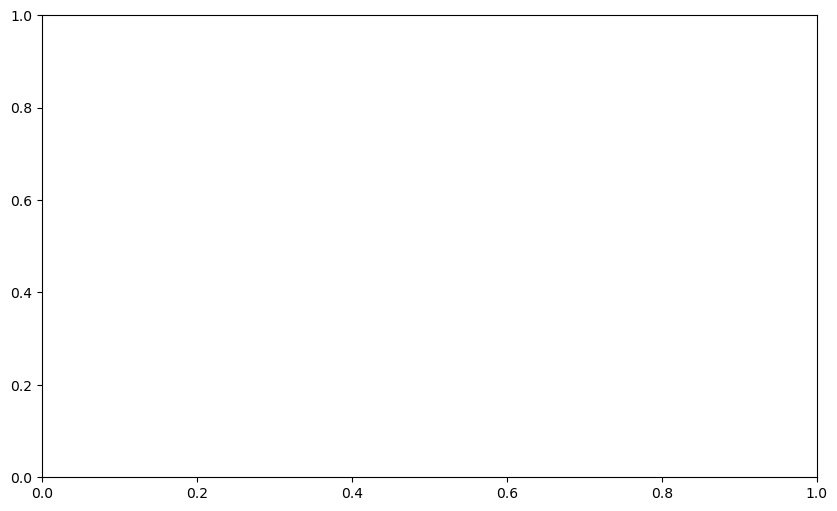

In [ ]:
plt.figure(figsize=(10, 6))

for layer in target_layers:
    k_vals, recoveries = sweep_results[layer]
    plt.plot(k_vals, recoveries, marker='o', label=f'Layer {layer}', linewidth=2)

plt.xlabel('Number of Top Features Patched (k)', fontsize=12)
plt.ylabel('Contact Recovery Score', fontsize=12) 
plt.title('Contact Recovery vs Number of Patched Features by Layer', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')  # Log scale for k values since they span wide range
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Results:")
print("=" * 50)
for layer in target_layers:
    k_vals, recoveries = sweep_results[layer]
    min_recovery = min(recoveries)
    max_recovery = max(recoveries) 
    print(f"Layer {layer:2d}: Recovery range [{min_recovery:.4f}, {max_recovery:.4f}]")

In [ ]:
def patch_top_k_features(target_layer, k_value, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches, 
                        saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL, 
                        _patching_metric, device, verbose=False):
    """
    Patch the top-k most important features for a given layer and return recovery score.
    
    Args:
        target_layer: Layer to patch
        k_value: Number of top features to patch
        ... (other arguments are the data structures from above)
        verbose: Whether to print debug info
    
    Returns:
        recovery: Contact recovery score after patching
    """
    
    # Get the SAE model and effects for this layer
    sae_model = saes[layer_2_saelayer[target_layer]]
    target_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[target_layer]]
    target_effect_sae_flat_LxS = target_effect_sae_LS.reshape(-1)
    
    # Get top-k indices
    top_rank_vals, top_idx = torch.topk(target_effect_sae_flat_LxS, k=k_value, largest=False, sorted=True)
    
    # Convert flattened indices back to 2D coordinates
    L, S = target_effect_sae_LS.shape
    row_indices = top_idx // S
    col_indices = top_idx % S
    
    if verbose:
        print(f"Layer {target_layer}, K={k_value}: Top effect = {top_rank_vals[0]:.6f}")
    
    # Create mask - start with all True (don't patch), set False for positions to patch
    sae_mask_LS = torch.ones((L, S), dtype=torch.bool, device=device)
    
    for i in range(len(top_idx)):
        row = row_indices[i]
        col = col_indices[i]
        sae_mask_LS[row, col] = False
    
    # Set up hook for patching
    hook = SAEHookProt(
        sae=sae_model,
        mask_BL=clean_batch_mask_BL,
        patch_mask_BLS=sae_mask_LS.to(device),
        patch_value=corr_layer_caches[target_layer].to(device),
        use_mean_error=True,
    )
    handle = esm_transformer.esm.encoder.layer[target_layer].register_forward_hook(hook)
    
    # Forward pass & metric
    with torch.no_grad():
        preds_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    recovery = _patching_metric(preds_LL)
    
    # Clean up
    handle.remove()
    cleanup_cuda()
    
    # Convert to CPU float for plotting
    if isinstance(recovery, torch.Tensor):
        recovery = recovery.cpu().item()
    
    return recovery

In [ ]:
# Define parameters for the sweep
target_layers = [4, 8, 12, 16, 20]  # You can modify this list
k_values = [1, 5, 10, 20, 50, 100, 200]  # You can modify this list

print("Starting k-value sweep across layers...")

# Clear memory before starting
sae_model_list, esm_transformer = clear_memory(saes, esm_transformer)
saes = sae_model_list

# Run the sweep
sweep_results = sweep_k_values(
    target_layers, k_values, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches,
    saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL,
    _patching_metric, device
)

print("Sweep complete!")

Starting k-value sweep across layers...

Processing layer 4...
Layer 4, K=1: Top effect = -0.025851
Layer 4, K=5: Top effect = -0.025851
Layer 4, K=10: Top effect = -0.025851
Layer 4, K=20: Top effect = -0.025851
Layer 4, K=50: Top effect = -0.025851
Layer 4, K=100: Top effect = -0.025851
Layer 4, K=200: Top effect = -0.025851
Layer 4 complete!

Processing layer 8...
Layer 8, K=1: Top effect = -0.017311
Layer 8, K=5: Top effect = -0.017311
Layer 8, K=10: Top effect = -0.017311
Layer 8, K=20: Top effect = -0.017311
Layer 8, K=50: Top effect = -0.017311
Layer 8, K=100: Top effect = -0.017311
Layer 8, K=200: Top effect = -0.017311
Layer 8 complete!

Processing layer 12...
Layer 12, K=1: Top effect = -0.022354
Layer 12, K=5: Top effect = -0.022354
Layer 12, K=10: Top effect = -0.022354
Layer 12, K=20: Top effect = -0.022354
Layer 12, K=50: Top effect = -0.022354
Layer 12, K=100: Top effect = -0.022354
Layer 12, K=200: Top effect = -0.022354
Layer 12 complete!

Processing layer 16...
Layer 

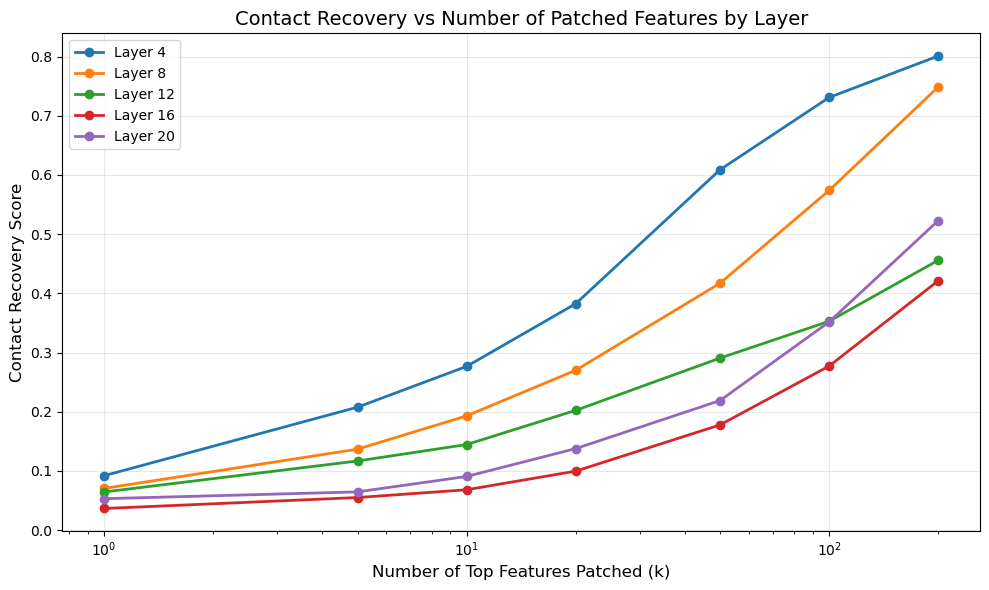


Summary Results:
Layer  4: Recovery range [0.0919, 0.8011]
Layer  8: Recovery range [0.0703, 0.7487]
Layer 12: Recovery range [0.0643, 0.4559]
Layer 16: Recovery range [0.0364, 0.4213]
Layer 20: Recovery range [0.0530, 0.5229]


In [ ]:
plt.figure(figsize=(10, 6))

for layer in target_layers:
    k_vals, recoveries = sweep_results[layer]
    plt.plot(k_vals, recoveries, marker='o', label=f'Layer {layer}', linewidth=2)

plt.xlabel('Number of Top Features Patched (k)', fontsize=12)
plt.ylabel('Contact Recovery Score', fontsize=12) 
plt.title('Contact Recovery vs Number of Patched Features by Layer', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')  # Log scale for k values since they span wide range
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Results:")
print("=" * 50)
for layer in target_layers:
    k_vals, recoveries = sweep_results[layer]
    min_recovery = min(recoveries)
    max_recovery = max(recoveries) 
    print(f"Layer {layer:2d}: Recovery range [{min_recovery:.4f}, {max_recovery:.4f}]")

In [ ]:
400*4096

1638400

In [ ]:
target_layer = 16
sae_model = saes[layer_2_saelayer[target_layer]]
corr_err_cache_BLF = corr_layer_errors[target_layer]
# put the mean error for that of clean 
sae_model.mean_error = corr_err_cache_BLF

# sae_hook = SAEHookProt(sae=sae_model, mask=clean_batch_mask_BL, patch_latent=torch.arange(4096), patch_value=corr_sae_cache_LS.to(device),cache_sae_acts=False, layer_lm=False, calc_error=False, use_error=False, use_mean_error=True)
sae_hook = SAEHookProt(sae=sae_model, mask=clean_batch_mask_BL, layer_lm=False, calc_error=False, use_error=False, use_mean_error=True)
hook = esm_transformer.esm.encoder.layer[target_layer].register_forward_hook(sae_hook)
with torch.no_grad():
    sanity_check_clean_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
hook.remove()
cleanup_cuda()
print(f"Layer {target_layer}, clean score: {_patching_metric(sanity_check_clean_contact_LL):.4f}")
# patching_metric(sanity_check_clean_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end)

TypeError: SAEHookProt.__init__() got an unexpected keyword argument 'mask'

In [ ]:
target_layer = 16
sae_model = saes[layer_2_saelayer[target_layer]]
corr_err_cache_BLF = corr_layer_errors[target_layer]
# put the mean error for that of clean 
sae_model.mean_error = corr_err_cache_BLF

# sae_hook = SAEHookProt(sae=sae_model, mask=clean_batch_mask_BL, patch_latent=torch.arange(4096), patch_value=corr_sae_cache_LS.to(device),cache_sae_acts=False, layer_lm=False, calc_error=False, use_error=False, use_mean_error=True)
sae_hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, layer_is_lm=False, calc_error=False, use_error=False, use_mean_error=True)
hook = esm_transformer.esm.encoder.layer[target_layer].register_forward_hook(sae_hook)
with torch.no_grad():
    sanity_check_clean_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
hook.remove()
cleanup_cuda()
print(f"Layer {target_layer}, clean score: {_patching_metric(sanity_check_clean_contact_LL):.4f}")
# patching_metric(sanity_check_clean_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end)

Layer 16, clean score: 0.2906


In [ ]:
target_layer = 16
sae_model = saes[layer_2_saelayer[target_layer]]
corr_err_cache_BLF = corr_layer_errors[target_layer]
clean_err_cache_BLF = clean_layer_errors[target_layer]
# put the mean error for that of clean 
sae_model.mean_error = clean_err_cache_BLF

sae_hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, patch_latent_S=torch.arange(4096), patch_value=corr_layer_caches[target_layer].to(device),cache_latents=False, layer_is_lm=False, calc_error=False, use_error=False, use_mean_error=True)
# sae_hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, layer_is_lm=False, calc_error=False, use_error=False, use_mean_error=True)
hook = esm_transformer.esm.encoder.layer[target_layer].register_forward_hook(sae_hook)
with torch.no_grad():
    sanity_check_clean_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
hook.remove()
cleanup_cuda()
print(f"Layer {target_layer}, clean score: {_patching_metric(sanity_check_clean_contact_LL):.4f}")
# patching_metric(sanity_check_clean_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end)

Layer 16, clean score: 0.0780


In [ ]:
def patch_top_k_features(target_layer, k_value, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches, 
                        saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL, 
                        clean_layer_errors, corr_layer_errors,
                        _patching_metric, device, verbose=False):
    """
    Patch the top-k most important features for a given layer and return recovery score.
    
    Args:
        target_layer: Layer to patch
        k_value: Number of top features to patch
        ... (other arguments are the data structures from above)
        verbose: Whether to print debug info
    
    Returns:
        recovery: Contact recovery score after patching
    """
    
    # Get the SAE model and effects for this layer
    sae_model = saes[layer_2_saelayer[target_layer]]
    
    # Set mean error to clean error for this layer
    sae_model.mean_error = clean_layer_errors[target_layer]
    
    target_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[target_layer]]
    target_effect_sae_flat_LxS = target_effect_sae_LS.reshape(-1)
    
    # Get top-k indices
    top_rank_vals, top_idx = torch.topk(target_effect_sae_flat_LxS, k=k_value, largest=False, sorted=True)
    
    # Convert flattened indices back to 2D coordinates
    L, S = target_effect_sae_LS.shape
    row_indices = top_idx // S
    col_indices = top_idx % S
    
    if verbose:
        print(f"Layer {target_layer}, K={k_value}: Top effect = {top_rank_vals[0]:.6f}")
    
    # Create mask - start with all True (don't patch), set False for positions to patch
    sae_mask_LS = torch.ones((L, S), dtype=torch.bool, device=device)
    
    for i in range(len(top_idx)):
        row = row_indices[i]
        col = col_indices[i]
        sae_mask_LS[row, col] = False
    
    # Set up hook for patching
    hook = SAEHookProt(
        sae=sae_model,
        mask_BL=clean_batch_mask_BL,
        patch_mask_BLS=sae_mask_LS.to(device),
        patch_value=corr_layer_caches[target_layer].to(device),
        use_mean_error=True,
    )
    handle = esm_transformer.esm.encoder.layer[target_layer].register_forward_hook(hook)
    
    # Forward pass & metric
    with torch.no_grad():
        preds_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    recovery = _patching_metric(preds_LL)
    
    # Clean up
    handle.remove()
    cleanup_cuda()
    
    # Convert to CPU float for plotting
    if isinstance(recovery, torch.Tensor):
        recovery = recovery.cpu().item()
    
    return recovery

In [ ]:
def sweep_k_values(target_layers, k_values, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches,
                  saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL,
                  clean_layer_errors, corr_layer_errors,
                  _patching_metric, device):
    """
    Sweep through k values for multiple target layers and collect recovery scores.
    
    Returns:
        results: Dictionary with layer as key, and (k_values, recoveries) as values
    """
    
    results = {}
    
    for target_layer in target_layers:
        print(f"\nProcessing layer {target_layer}...")
        recoveries = []
        
        for k in k_values:
            recovery = patch_top_k_features(
                target_layer, k, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches,
                saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL,
                clean_layer_errors, corr_layer_errors,
                _patching_metric, device, verbose=True
            )
            recoveries.append(recovery)
            
        results[target_layer] = (k_values, recoveries)
        print(f"Layer {target_layer} complete!")
    
    return results

In [ ]:
# Define parameters for the sweep
target_layers = [4, 8, 12, 16, 20]  # You can modify this list
k_values = [1, 5, 10, 20, 50, 100, 200]  # You can modify this list

print("Starting k-value sweep across layers...")

# Clear memory before starting
sae_model_list, esm_transformer = clear_memory(saes, esm_transformer)
saes = sae_model_list

# Run the sweep
sweep_results = sweep_k_values(
    target_layers, k_values, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches,
    saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL,
    clean_layer_errors, corr_layer_errors,
    _patching_metric, device
)

print("Sweep complete!")

Starting k-value sweep across layers...

Processing layer 4...
Layer 4, K=1: Top effect = -0.025851
Layer 4, K=5: Top effect = -0.025851
Layer 4, K=10: Top effect = -0.025851
Layer 4, K=20: Top effect = -0.025851
Layer 4, K=50: Top effect = -0.025851
Layer 4, K=100: Top effect = -0.025851
Layer 4, K=200: Top effect = -0.025851
Layer 4 complete!

Processing layer 8...
Layer 8, K=1: Top effect = -0.017311
Layer 8, K=5: Top effect = -0.017311
Layer 8, K=10: Top effect = -0.017311
Layer 8, K=20: Top effect = -0.017311
Layer 8, K=50: Top effect = -0.017311
Layer 8, K=100: Top effect = -0.017311
Layer 8, K=200: Top effect = -0.017311
Layer 8 complete!

Processing layer 12...
Layer 12, K=1: Top effect = -0.022354
Layer 12, K=5: Top effect = -0.022354
Layer 12, K=10: Top effect = -0.022354
Layer 12, K=20: Top effect = -0.022354
Layer 12, K=50: Top effect = -0.022354
Layer 12, K=100: Top effect = -0.022354
Layer 12, K=200: Top effect = -0.022354
Layer 12 complete!

Processing layer 16...
Layer 

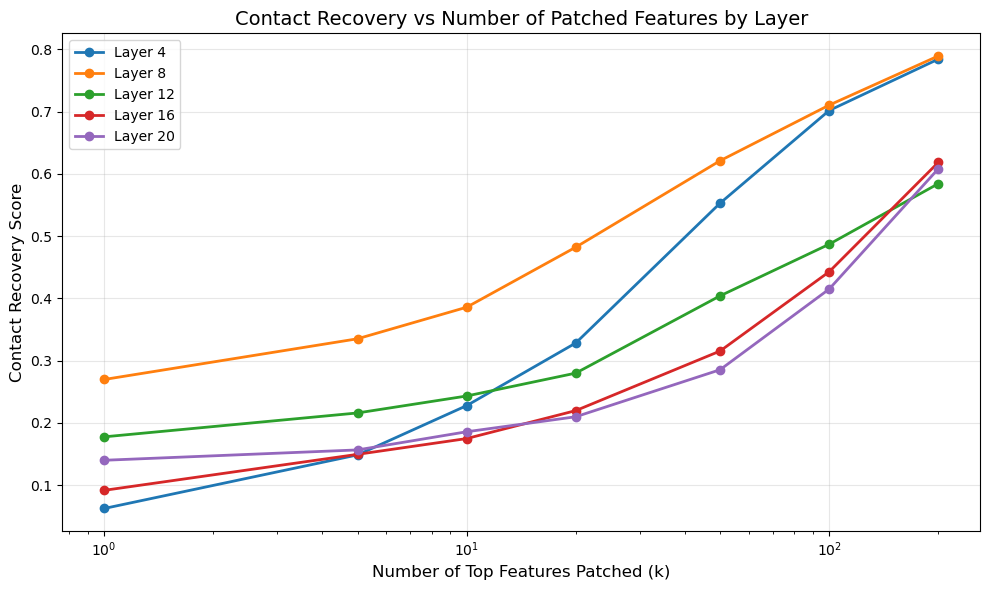


Summary Results:
Layer  4: Recovery range [0.0623, 0.7843]
Layer  8: Recovery range [0.2696, 0.7894]
Layer 12: Recovery range [0.1774, 0.5842]
Layer 16: Recovery range [0.0915, 0.6184]
Layer 20: Recovery range [0.1398, 0.6081]


In [ ]:
plt.figure(figsize=(10, 6))

for layer in target_layers:
    k_vals, recoveries = sweep_results[layer]
    plt.plot(k_vals, recoveries, marker='o', label=f'Layer {layer}', linewidth=2)

plt.xlabel('Number of Top Features Patched (k)', fontsize=12)
plt.ylabel('Contact Recovery Score', fontsize=12) 
plt.title('Contact Recovery vs Number of Patched Features by Layer', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')  # Log scale for k values since they span wide range
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Results:")
print("=" * 50)
for layer in target_layers:
    k_vals, recoveries = sweep_results[layer]
    min_recovery = min(recoveries)
    max_recovery = max(recoveries) 
    print(f"Layer {layer:2d}: Recovery range [{min_recovery:.4f}, {max_recovery:.4f}]")

In [ ]:
target_layer = 20
sae_model = saes[layer_2_saelayer[target_layer]]
corr_err_cache_BLF = corr_layer_errors[target_layer]
clean_err_cache_BLF = clean_layer_errors[target_layer]
# put the mean error for that of clean 
sae_model.mean_error = clean_err_cache_BLF

sae_hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, patch_latent_S=torch.arange(4096), patch_value=corr_layer_caches[target_layer].to(device),cache_latents=False, layer_is_lm=False, calc_error=False, use_error=False, use_mean_error=True)
# sae_hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, layer_is_lm=False, calc_error=False, use_error=False, use_mean_error=True)
hook = esm_transformer.esm.encoder.layer[target_layer].register_forward_hook(sae_hook)
with torch.no_grad():
    sanity_check_clean_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
hook.remove()
cleanup_cuda()
print(f"Layer {target_layer}, clean score: {_patching_metric(sanity_check_clean_contact_LL):.4f}")
# patching_metric(sanity_check_clean_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end)

Layer 20, clean score: 0.1119


In [ ]:
target_layer = 12
sae_model = saes[layer_2_saelayer[target_layer]]
corr_err_cache_BLF = corr_layer_errors[target_layer]
clean_err_cache_BLF = clean_layer_errors[target_layer]
# put the mean error for that of clean 
sae_model.mean_error = clean_err_cache_BLF

sae_hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, patch_latent_S=torch.arange(4096), patch_value=corr_layer_caches[target_layer].to(device),cache_latents=False, layer_is_lm=False, calc_error=False, use_error=False, use_mean_error=True)
# sae_hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, layer_is_lm=False, calc_error=False, use_error=False, use_mean_error=True)
hook = esm_transformer.esm.encoder.layer[target_layer].register_forward_hook(sae_hook)
with torch.no_grad():
    sanity_check_clean_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
hook.remove()
cleanup_cuda()
print(f"Layer {target_layer}, clean score: {_patching_metric(sanity_check_clean_contact_LL):.4f}")
# patching_metric(sanity_check_clean_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end)

Layer 12, clean score: 0.1565


In [ ]:
target_layer = 8
sae_model = saes[layer_2_saelayer[target_layer]]
corr_err_cache_BLF = corr_layer_errors[target_layer]
clean_err_cache_BLF = clean_layer_errors[target_layer]
# put the mean error for that of clean 
sae_model.mean_error = clean_err_cache_BLF

sae_hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, patch_latent_S=torch.arange(4096), patch_value=corr_layer_caches[target_layer].to(device),cache_latents=False, layer_is_lm=False, calc_error=False, use_error=False, use_mean_error=True)
# sae_hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, layer_is_lm=False, calc_error=False, use_error=False, use_mean_error=True)
hook = esm_transformer.esm.encoder.layer[target_layer].register_forward_hook(sae_hook)
with torch.no_grad():
    sanity_check_clean_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
hook.remove()
cleanup_cuda()
print(f"Layer {target_layer}, clean score: {_patching_metric(sanity_check_clean_contact_LL):.4f}")
# patching_metric(sanity_check_clean_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end)

Layer 8, clean score: 0.2553


In [ ]:
all_effects_sae_ALS.shape

torch.Size([7, 379, 4096])

In [ ]:
# Define parameters for the sweep
target_layers = [4, 8, 12, 16, 20, 24, 28]  # You can modify this list
k_values = [1, 5, 10, 20, 50, 100, 200]  # You can modify this list

print("Starting k-value sweep across layers...")

# Clear memory before starting
sae_model_list, esm_transformer = clear_memory(saes, esm_transformer)
saes = sae_model_list

# Run the sweep
sweep_results = sweep_k_values(
    target_layers, k_values, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches,
    saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL,
    clean_layer_errors, corr_layer_errors,
    _patching_metric, device
)

print("Sweep complete!")

Starting k-value sweep across layers...

Processing layer 4...
Layer 4, K=1: Top effect = -0.025851
Layer 4, K=5: Top effect = -0.025851
Layer 4, K=10: Top effect = -0.025851
Layer 4, K=20: Top effect = -0.025851
Layer 4, K=50: Top effect = -0.025851
Layer 4, K=100: Top effect = -0.025851
Layer 4, K=200: Top effect = -0.025851
Layer 4 complete!

Processing layer 8...
Layer 8, K=1: Top effect = -0.017311
Layer 8, K=5: Top effect = -0.017311
Layer 8, K=10: Top effect = -0.017311
Layer 8, K=20: Top effect = -0.017311
Layer 8, K=50: Top effect = -0.017311
Layer 8, K=100: Top effect = -0.017311
Layer 8, K=200: Top effect = -0.017311
Layer 8 complete!

Processing layer 12...
Layer 12, K=1: Top effect = -0.022354
Layer 12, K=5: Top effect = -0.022354
Layer 12, K=10: Top effect = -0.022354
Layer 12, K=20: Top effect = -0.022354
Layer 12, K=50: Top effect = -0.022354
Layer 12, K=100: Top effect = -0.022354
Layer 12, K=200: Top effect = -0.022354
Layer 12 complete!

Processing layer 16...
Layer 

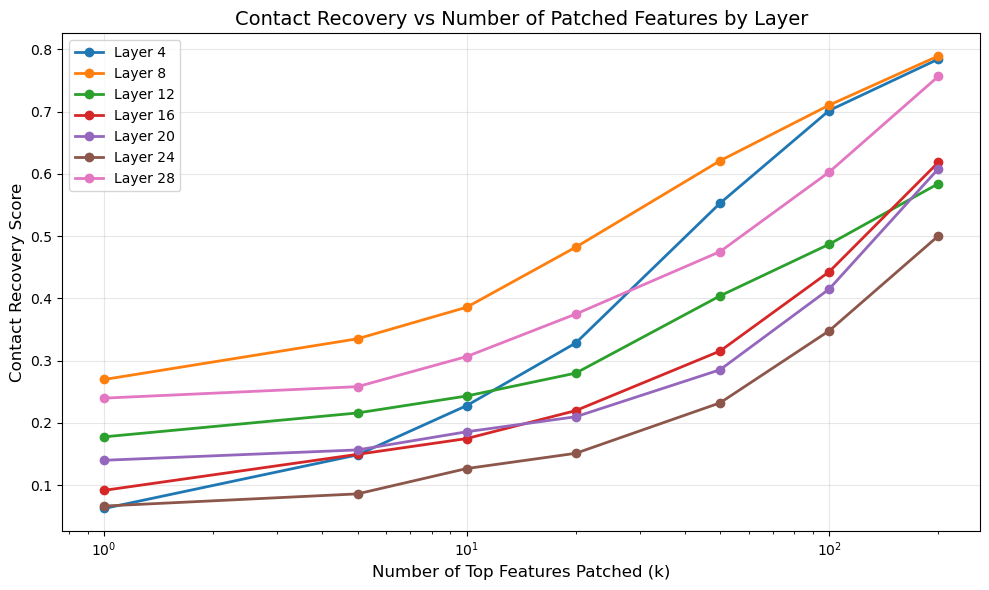


Summary Results:
Layer  4: Recovery range [0.0623, 0.7843]
Layer  8: Recovery range [0.2696, 0.7894]
Layer 12: Recovery range [0.1774, 0.5842]
Layer 16: Recovery range [0.0915, 0.6184]
Layer 20: Recovery range [0.1398, 0.6081]
Layer 24: Recovery range [0.0662, 0.5002]
Layer 28: Recovery range [0.2396, 0.7566]


In [ ]:
plt.figure(figsize=(10, 6))

for layer in target_layers:
    k_vals, recoveries = sweep_results[layer]
    plt.plot(k_vals, recoveries, marker='o', label=f'Layer {layer}', linewidth=2)

plt.xlabel('Number of Top Features Patched (k)', fontsize=12)
plt.ylabel('Contact Recovery Score', fontsize=12) 
plt.title('Contact Recovery vs Number of Patched Features by Layer', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')  # Log scale for k values since they span wide range
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Results:")
print("=" * 50)
for layer in target_layers:
    k_vals, recoveries = sweep_results[layer]
    min_recovery = min(recoveries)
    max_recovery = max(recoveries) 
    print(f"Layer {layer:2d}: Recovery range [{min_recovery:.4f}, {max_recovery:.4f}]")

In [ ]:
print("Testing gating hypothesis: Corrupting layer 4, caching layer 8...")

# Define layers for the gating test
corrupt_layer = 4
cache_layer = 8

# Get top-k positions for layer 4 (to corrupt)
k_corrupt = 10
sae_model_corrupt = saes[layer_2_saelayer[corrupt_layer]]
sae_model_corrupt.mean_error = clean_layer_errors[corrupt_layer]

target_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[corrupt_layer]]
target_effect_sae_flat_LxS = target_effect_sae_LS.reshape(-1)
top_rank_vals, top_idx = torch.topk(target_effect_sae_flat_LxS, k=k_corrupt, largest=False, sorted=True)

# Convert to 2D coordinates
L, S = target_effect_sae_LS.shape
row_indices = top_idx // S
col_indices = top_idx % S

print(f"Corrupting top {k_corrupt} features in layer {corrupt_layer}")
print(f"Top effect value: {top_rank_vals[0]:.6f}")

# Create corruption mask for layer 4 - True means corrupt these positions
corrupt_mask_LS = torch.zeros((L, S), dtype=torch.bool, device=device)
for i in range(len(top_idx)):
    row = row_indices[i]
    col = col_indices[i]
    corrupt_mask_LS[row, col] = True

# Setup caching SAE for layer 8
sae_model_cache = saes[layer_2_saelayer[cache_layer]]
sae_model_cache.mean_error = clean_layer_errors[cache_layer]

# Use pre-computed clean activations for layer 8
print("Using pre-computed clean activations for layer 8...")
baseline_acts_layer8 = clean_layer_caches[cache_layer].clone()

# We also know the baseline score from when we computed the clean caches
# But let's get it for reference
with torch.no_grad():
    baseline_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
baseline_score = _patching_metric(baseline_contact_LL)
print(f"Baseline score: {baseline_score:.4f}")

# Now, corrupt layer 4 and cache layer 8 activations
print("Corrupting layer 4 and caching layer 8...")

# Setup corruption hook for layer 4
corrupt_hook = SAEHookProt(
    sae=sae_model_corrupt,
    mask_BL=clean_batch_mask_BL,
    patch_mask_BLS=corrupt_mask_LS.to(device),
    patch_value=corr_layer_caches[corrupt_layer].to(device),
    use_mean_error=True,
)

# Setup caching hook for layer 8
cache_hook = SAEHookProt(
    sae=sae_model_cache,
    mask_BL=clean_batch_mask_BL,
    cache_latents=True,
    layer_is_lm=False,
    calc_error=False,
    use_error=False,
    use_mean_error=True
)

# Register both hooks
corrupt_handle = esm_transformer.esm.encoder.layer[corrupt_layer].register_forward_hook(corrupt_hook)
cache_handle = esm_transformer.esm.encoder.layer[cache_layer].register_forward_hook(cache_hook)

# Forward pass with corruption
with torch.no_grad():
    corrupted_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]

# Clean up hooks
corrupt_handle.remove()
cache_handle.remove()
cleanup_cuda()

# Get the activations after corruption
corrupted_acts_layer8 = sae_model_cache.feature_acts.clone()
corrupted_score = _patching_metric(corrupted_contact_LL)

Testing gating hypothesis: Corrupting layer 4, caching layer 8...
Corrupting top 10 features in layer 4
Top effect value: -0.025851
Using pre-computed clean activations for layer 8...
Baseline score: 0.5738
Corrupting layer 4 and caching layer 8...


In [ ]:
print("Testing gating hypothesis: Corrupting layer 4, caching layer 8...")

# Define layers for the gating test
corrupt_layer = 4
cache_layer = 8

# Get top-k positions for layer 4 (to corrupt)
k_corrupt = 10
sae_model_corrupt = saes[layer_2_saelayer[corrupt_layer]]
sae_model_corrupt.mean_error = clean_layer_errors[corrupt_layer]

target_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[corrupt_layer]]
target_effect_sae_flat_LxS = target_effect_sae_LS.reshape(-1)
top_rank_vals, top_idx = torch.topk(target_effect_sae_flat_LxS, k=k_corrupt, largest=False, sorted=True)

# Convert to 2D coordinates
L, S = target_effect_sae_LS.shape
row_indices = top_idx // S
col_indices = top_idx % S

print(f"Corrupting top {k_corrupt} features in layer {corrupt_layer}")
print(f"Top effect value: {top_rank_vals[0]:.6f}")

# Create corruption mask for layer 4 - True means corrupt these positions
corrupt_mask_LS = torch.zeros((L, S), dtype=torch.bool, device=device)
for i in range(len(top_idx)):
    row = row_indices[i]
    col = col_indices[i]
    corrupt_mask_LS[row, col] = True

# Setup caching SAE for layer 8
sae_model_cache = saes[layer_2_saelayer[cache_layer]]
sae_model_cache.mean_error = clean_layer_errors[cache_layer]

# Use pre-computed clean activations for layer 8
print("Using pre-computed clean activations for layer 8...")
baseline_acts_layer8 = clean_layer_caches[cache_layer].clone()

# We also know the baseline score from when we computed the clean caches
# But let's get it for reference
with torch.no_grad():
    baseline_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
baseline_score = _patching_metric(baseline_contact_LL)
print(f"Baseline score: {baseline_score:.4f}")

# Now, corrupt layer 4 and cache layer 8 activations
print("Corrupting layer 4 and caching layer 8...")

# Setup corruption hook for layer 4
corrupt_hook = SAEHookProt(
    sae=sae_model_corrupt,
    mask_BL=clean_batch_mask_BL,
    patch_mask_BLS=corrupt_mask_LS.to(device),
    patch_value=corr_layer_caches[corrupt_layer].to(device),
    use_mean_error=True,
)

# Setup caching hook for layer 8
cache_hook = SAEHookProt(
    sae=sae_model_cache,
    mask_BL=clean_batch_mask_BL,
    cache_latents=True,
    layer_is_lm=False,
    calc_error=False,
    use_error=False,
    use_mean_error=True
)

# Register both hooks
corrupt_handle = esm_transformer.esm.encoder.layer[corrupt_layer].register_forward_hook(corrupt_hook)
cache_handle = esm_transformer.esm.encoder.layer[cache_layer].register_forward_hook(cache_hook)

# Forward pass with corruption
with torch.no_grad():
    corrupted_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]

# Clean up hooks
corrupt_handle.remove()
cache_handle.remove()
cleanup_cuda()

# Get the activations after corruption
corrupted_acts_layer8 = sae_model_cache.feature_acts.clone()
corrupted_score = _patching_metric(corrupted_contact_LL)

print(f"Score after corrupting layer {corrupt_layer}: {corrupted_score:.4f}")
print(f"Score change: {corrupted_score - baseline_score:.6f}")

Testing gating hypothesis: Corrupting layer 4, caching layer 8...
Corrupting top 10 features in layer 4
Top effect value: -0.025851
Using pre-computed clean activations for layer 8...
Baseline score: 0.5738
Corrupting layer 4 and caching layer 8...
Score after corrupting layer 4: 0.4638
Score change: -0.109966


In [ ]:
# Analyze the activation changes for causally important features in layer 8
activation_diff = corrupted_acts_layer8 - baseline_acts_layer8

# Get the top causally relevant pairs for layer 8
k_important = 50
layer8_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[cache_layer]]
layer8_effect_sae_flat = layer8_effect_sae_LS.reshape(-1)
layer8_top_vals, layer8_top_idx = torch.topk(layer8_effect_sae_flat, k=k_important, largest=False, sorted=True)

# Convert to 2D coordinates for layer 8
L8, S8 = layer8_effect_sae_LS.shape
layer8_row_indices = layer8_top_idx // S8
layer8_col_indices = layer8_top_idx % S8

print(f"\nAnalyzing changes in top {k_important} causally important features in layer {cache_layer}:")
print(f"Most important feature effect: {layer8_top_vals[0]:.6f}")

# Extract activation changes for these specific important positions
important_activation_changes = []
for i in range(k_important):
    row = layer8_row_indices[i]
    col = layer8_col_indices[i]
    change = activation_diff[row, col].item()
    causal_effect = layer8_top_vals[i].item()
    important_activation_changes.append((i, row.item(), col.item(), change, causal_effect))

# Sort by magnitude of activation change
important_activation_changes.sort(key=lambda x: abs(x[3]), reverse=True)

print(f"\nTop 15 causally important features with largest activation changes:")
print("Rank | (Token, Latent) | Act Change | Causal Effect | Change/Effect Ratio")
print("-" * 75)
for i in range(min(15, len(important_activation_changes))):
    rank, row, col, change, effect = important_activation_changes[i]
    ratio = change / effect if abs(effect) > 1e-8 else float('inf')
    print(f"{rank+1:4d} | ({row:3d}, {col:4d}) | {change:+9.6f} | {effect:9.6f} | {ratio:+9.3f}")

# Calculate statistics specifically for the causally important features
important_changes = torch.tensor([x[3] for x in important_activation_changes])
important_effects = torch.tensor([x[4] for x in important_activation_changes])

print(f"\nStatistics for causally important features in layer {cache_layer}:")
print(f"Mean absolute activation change: {torch.mean(torch.abs(important_changes)):.6f}")
print(f"Max increase in important features: {torch.max(important_changes):.6f}")
print(f"Max decrease in important features: {torch.min(important_changes):.6f}")
print(f"Fraction of important features that increased: {(important_changes > 0).float().mean():.3f}")
print(f"Fraction of important features that decreased: {(important_changes < 0).float().mean():.3f}")

# Check correlation between causal importance and activation change magnitude
abs_changes = torch.abs(important_changes)
abs_effects = torch.abs(important_effects)
correlation = torch.corrcoef(torch.stack([abs_changes, abs_effects]))[0, 1]
print(f"Correlation between |causal effect| and |activation change|: {correlation:.4f}")

# Global statistics for comparison
print(f"\nGlobal activation change statistics:")
print(f"Mean absolute change (all features): {torch.mean(torch.abs(activation_diff)):.6f}")
print(f"Mean absolute change (important features): {torch.mean(abs_changes):.6f}")
print(f"Important features are {torch.mean(abs_changes) / torch.mean(torch.abs(activation_diff)):.2f}x more affected on average")


Analyzing changes in top 50 causally important features in layer 8:
Most important feature effect: -0.017311

Top 15 causally important features with largest activation changes:
Rank | (Token, Latent) | Act Change | Causal Effect | Change/Effect Ratio
---------------------------------------------------------------------------
  38 | (317, 3384) | +0.458150 | -0.003367 |  -136.075
  10 | (180, 3921) | +0.350607 | -0.008497 |   -41.265
  13 | (316, 3381) | -0.272113 | -0.007934 |   +34.299
   8 | (316, 1575) | +0.271082 | -0.010670 |   -25.405
   4 | (316, 2486) | +0.242840 | -0.013317 |   -18.235
  35 | (316, 2209) | -0.233554 | -0.003620 |   +64.510
  36 | (316, 1605) | -0.231130 | -0.003522 |   +65.625
  30 | (316, 1591) | +0.218420 | -0.004837 |   -45.158
  12 | (316, 3092) | +0.212620 | -0.008146 |   -26.100
   7 | (316,  431) | -0.207576 | -0.012764 |   +16.263
  23 | (316, 2662) | +0.207370 | -0.005610 |   -36.966
   1 | (316,  488) | -0.183264 | -0.017311 |   +10.587
  11 | (316

In [ ]:
def test_gating_hypothesis(corrupt_layer, downstream_layers, k_corrupt, k_test, num_random_trials=5):
    """
    Test gating hypothesis: corrupt one layer and measure effects on downstream layers.
    
    Args:
        corrupt_layer: Layer to corrupt
        downstream_layers: List of layers to test effects on
        k_corrupt: Number of top features to corrupt in corrupt_layer
        k_test: Number of features to test in downstream layers (both important and random)
        num_random_trials: Number of random control groups to test
    
    Returns:
        results: Dictionary with detailed results for each downstream layer
    """
    
    print(f"\n{'='*60}")
    print(f"GATING HYPOTHESIS TEST: Corrupt Layer {corrupt_layer}")
    print(f"Downstream layers: {downstream_layers}")
    print(f"Corrupting top {k_corrupt} features, testing {k_test} features each")
    print(f"{'='*60}")
    
    results = {}
    
    # Get corruption targets for the corrupt layer
    sae_model_corrupt = saes[layer_2_saelayer[corrupt_layer]]
    sae_model_corrupt.mean_error = clean_layer_errors[corrupt_layer]
    
    corrupt_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[corrupt_layer]]
    corrupt_effect_flat = corrupt_effect_sae_LS.reshape(-1)
    corrupt_top_vals, corrupt_top_idx = torch.topk(corrupt_effect_flat, k=k_corrupt, largest=False, sorted=True)
    
    # Convert to 2D coordinates for corruption
    L_corrupt, S_corrupt = corrupt_effect_sae_LS.shape
    corrupt_row_indices = corrupt_top_idx // S_corrupt
    corrupt_col_indices = corrupt_top_idx % S_corrupt
    
    # Create corruption mask
    corrupt_mask_LS = torch.zeros((L_corrupt, S_corrupt), dtype=torch.bool, device=device)
    for i in range(len(corrupt_top_idx)):
        row = corrupt_row_indices[i]
        col = corrupt_col_indices[i]
        corrupt_mask_LS[row, col] = True
    
    print(f"Corrupting layer {corrupt_layer}: Top effect = {corrupt_top_vals[0]:.6f}")
    
    # Test each downstream layer
    for cache_layer in downstream_layers:
        print(f"\n--- Testing effects on layer {cache_layer} ---")
        
        # Setup caching for this downstream layer
        sae_model_cache = saes[layer_2_saelayer[cache_layer]]
        sae_model_cache.mean_error = clean_layer_errors[cache_layer]
        
        # Get baseline activations (pre-computed)
        baseline_acts = clean_layer_caches[cache_layer].clone()
        
        # Setup hooks: corruption + caching
        corrupt_hook = SAEHookProt(
            sae=sae_model_corrupt,
            mask_BL=clean_batch_mask_BL,
            patch_mask_BLS=corrupt_mask_LS.to(device),
            patch_value=corr_layer_caches[corrupt_layer].to(device),
            use_mean_error=True,
        )
        
        cache_hook = SAEHookProt(
            sae=sae_model_cache,
            mask_BL=clean_batch_mask_BL,
            cache_latents=True,
            layer_is_lm=False,
            calc_error=False,
            use_error=False,
            use_mean_error=True
        )
        
        # Forward pass with corruption
        corrupt_handle = esm_transformer.esm.encoder.layer[corrupt_layer].register_forward_hook(corrupt_hook)
        cache_handle = esm_transformer.esm.encoder.layer[cache_layer].register_forward_hook(cache_hook)
        
        with torch.no_grad():
            _ = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
        
        corrupt_handle.remove()
        cache_handle.remove()
        cleanup_cuda()
        
        # Get corrupted activations
        corrupted_acts = sae_model_cache.feature_acts.clone()
        activation_diff = torch.abs(corrupted_acts - baseline_acts)
        
        # Get important features for this downstream layer
        cache_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[cache_layer]]
        cache_effect_flat = cache_effect_sae_LS.reshape(-1)
        cache_top_vals, cache_top_idx = torch.topk(cache_effect_flat, k=k_test, largest=False, sorted=True)
        
        # Convert to 2D coordinates
        L_cache, S_cache = cache_effect_sae_LS.shape
        cache_row_indices = cache_top_idx // S_cache
        cache_col_indices = cache_top_idx % S_cache
        
        # Extract changes for important features
        important_changes = []
        for i in range(k_test):
            row = cache_row_indices[i]
            col = cache_col_indices[i]
            change = activation_diff[row, col].item()
            important_changes.append(change)
        
        important_mean = np.mean(important_changes)
        important_median = np.median(important_changes)
        
        # Test against multiple random control groups
        random_means = []
        random_medians = []
        
        for trial in range(num_random_trials):
            # Generate random (token, latent) pairs
            random_rows = torch.randint(0, L_cache, (k_test,))
            random_cols = torch.randint(0, S_cache, (k_test,))
            
            random_changes = []
            for i in range(k_test):
                row = random_rows[i]
                col = random_cols[i]
                change = activation_diff[row, col].item()
                random_changes.append(change)
            
            random_means.append(np.mean(random_changes))
            random_medians.append(np.median(random_changes))
        
        # Calculate statistics
        random_mean_avg = np.mean(random_means)
        random_median_avg = np.mean(random_medians)
        random_mean_std = np.std(random_means)
        random_median_std = np.std(random_medians)
        
        # Effect sizes
        mean_effect_size = (important_mean - random_mean_avg) / random_mean_std if random_mean_std > 0 else float('inf')
        median_effect_size = (important_median - random_median_avg) / random_median_std if random_median_std > 0 else float('inf')
        
        # Store results
        layer_results = {
            'important_mean': important_mean,
            'important_median': important_median,
            'random_mean_avg': random_mean_avg,
            'random_median_avg': random_median_avg,
            'random_mean_std': random_mean_std,
            'random_median_std': random_median_std,
            'mean_effect_size': mean_effect_size,
            'median_effect_size': median_effect_size,
            'mean_ratio': important_mean / random_mean_avg if random_mean_avg > 0 else float('inf'),
            'median_ratio': important_median / random_median_avg if random_median_avg > 0 else float('inf'),
            'important_changes': important_changes,
            'random_means': random_means,
            'random_medians': random_medians
        }
        
        results[cache_layer] = layer_results
        
        # Print results
        print(f"Important features - Mean: {important_mean:.6f}, Median: {important_median:.6f}")
        print(f"Random features   - Mean: {random_mean_avg:.6f}±{random_mean_std:.6f}, Median: {random_median_avg:.6f}±{random_median_std:.6f}")
        print(f"Effect sizes      - Mean: {mean_effect_size:.3f}, Median: {median_effect_size:.3f}")
        print(f"Ratios            - Mean: {important_mean/random_mean_avg:.3f}x, Median: {important_median/random_median_avg:.3f}x")
        
        # Simple significance test (important > all random trials)
        mean_wins = sum(1 for rm in random_means if important_mean > rm)
        median_wins = sum(1 for rm in random_medians if important_median > rm)
        print(f"Significance      - Mean: {mean_wins}/{num_random_trials}, Median: {median_wins}/{num_random_trials}")
        
    return results

In [ ]:
# Parameters
k_corrupt = 50  # Number of features to corrupt in source layer
k_test = 50     # Number of features to test in downstream layers
num_random_trials = 10  # Number of random control groups

# Target layers from your existing analysis
test_layers = [4, 8, 12, 16, 20, 24, 28]

# Store all results
all_gating_results = {}

# Test each layer on all downstream layers
for corrupt_layer in test_layers:
    downstream_layers = [layer for layer in test_layers if layer > corrupt_layer]
    if len(downstream_layers) > 0:
        results = test_gating_hypothesis(corrupt_layer, downstream_layers, k_corrupt, k_test, num_random_trials)
        all_gating_results[corrupt_layer] = results


GATING HYPOTHESIS TEST: Corrupt Layer 4
Downstream layers: [8, 12, 16, 20, 24, 28]
Corrupting top 50 features, testing 50 features each
Corrupting layer 4: Top effect = -0.025851

--- Testing effects on layer 8 ---
Important features - Mean: 0.222863, Median: 0.191855
Random features   - Mean: 0.024839±0.005145, Median: 0.017470±0.003870
Effect sizes      - Mean: 38.491, Median: 45.062
Ratios            - Mean: 8.972x, Median: 10.982x
Significance      - Mean: 10/10, Median: 10/10

--- Testing effects on layer 12 ---
Important features - Mean: 0.964153, Median: 0.806816
Random features   - Mean: 0.108997±0.015466, Median: 0.073261±0.012631
Effect sizes      - Mean: 55.294, Median: 58.076
Ratios            - Mean: 8.846x, Median: 11.013x
Significance      - Mean: 10/10, Median: 10/10

--- Testing effects on layer 16 ---
Important features - Mean: 1.734190, Median: 1.319716
Random features   - Mean: 0.235292±0.032914, Median: 0.147875±0.026337
Effect sizes      - Mean: 45.540, Median: 4